<a href="https://colab.research.google.com/github/bisrat-walle/Reinforcement-Learning/blob/main/Exercise_I_Introduction_to_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning Algorithms

This notebook implements and visualizes various reinforcement learning algorithms for the Grid World and Single-State Multi-Armed Bandit problems.

## Setup

First, we install the necessary libraries.


In [ ]:
!pip install gymnasium numpy matplotlib

## Grid World Problem

We will apply Value Iteration, Policy Iteration, and Q-Learning algorithms to the Grid World problem.


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Create the environment
env = gym.make("FrozenLake-v1", is_slippery=False)

# Initialize variables
n_states = env.observation_space.n
n_actions = env.action_space.n


### Value Iteration


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


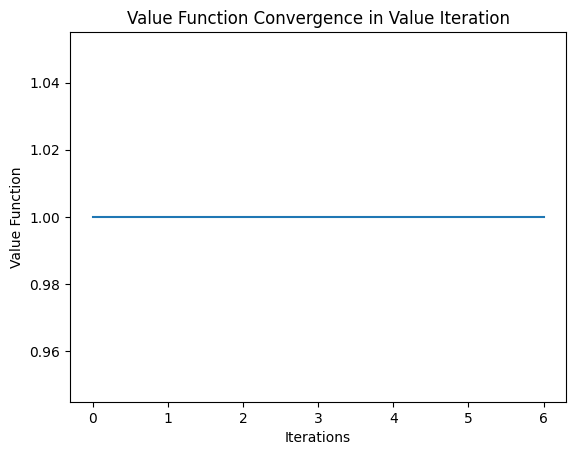

Optimal Value Function: [0.95099005 0.96059601 0.970299   0.96059601 0.96059601 0.
 0.9801     0.         0.970299   0.9801     0.99       0.
 0.         0.99       1.         0.        ]


In [ ]:
def value_iteration(env, gamma=0.99, epsilon=1e-6):
    value_table = np.zeros(n_states)
    value_history = []
    while True:
        updated_value_table = np.copy(value_table)
        for state in range(n_states):
            Q_value = []
            for action in range(n_actions):
                q_value = 0
                for prob, next_state, reward, done in env.P[state][action]:
                    q_value += prob * (reward + gamma * value_table[next_state])
                Q_value.append(q_value)
            value_table[state] = max(Q_value)

        value_history.append(np.copy(value_table))
        if np.sum(np.fabs(updated_value_table - value_table)) <= epsilon:
            break
    return value_table, value_history

optimal_value_function, value_history = value_iteration(env)

# Plotting value function over iterations
plt.plot(np.arange(len(value_history)), [np.max(v) for v in value_history])
plt.xlabel('Iterations')
plt.ylabel('Value Function')
plt.title('Value Function Convergence in Value Iteration')
plt.show()

print("Optimal Value Function:", optimal_value_function)


### Policy Iteration


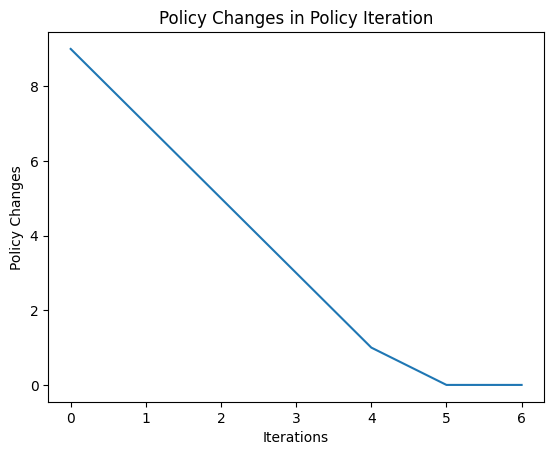

Optimal Policy: [1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]


In [ ]:
def policy_evaluation(policy, env, gamma=0.99, epsilon=1e-6):
    value_table = np.zeros(n_states)
    while True:
        updated_value_table = np.copy(value_table)
        for state in range(n_states):
            action = policy[state]
            q_value = 0
            for prob, next_state, reward, done in env.P[state][action]:
                q_value += prob * (reward + gamma * value_table[next_state])
            value_table[state] = q_value

        if np.sum(np.fabs(updated_value_table - value_table)) <= epsilon:
            break
    return value_table

def policy_iteration(env, gamma=0.99):
    policy = np.random.choice(n_actions, n_states)
    policy_history = []
    while True:
        value_table = policy_evaluation(policy, env, gamma)
        policy_stable = True
        for state in range(n_states):
            old_action = policy[state]
            Q_value = []
            for action in range(n_actions):
                q_value = 0
                for prob, next_state, reward, done in env.P[state][action]:
                    q_value += prob * (reward + gamma * value_table[next_state])
                Q_value.append(q_value)
            policy[state] = np.argmax(Q_value)
            if old_action != policy[state]:
                policy_stable = False

        policy_history.append(np.copy(policy))
        if policy_stable:
            break
    return policy, policy_history

optimal_policy, policy_history = policy_iteration(env)

# Plotting policy changes over iterations
iterations = np.arange(len(policy_history))
changes = [np.sum(p != policy_history[-1]) for p in policy_history]

plt.plot(iterations, changes)
plt.xlabel('Iterations')
plt.ylabel('Policy Changes')
plt.title('Policy Changes in Policy Iteration')
plt.show()

print("Optimal Policy:", optimal_policy)


### Q-Learning

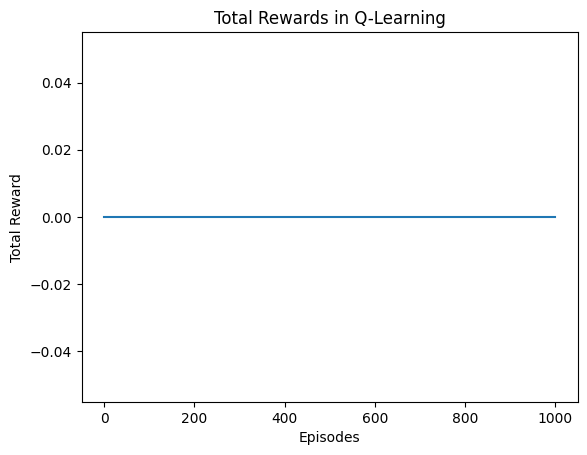

Q-Table: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [ ]:
def q_learning(env, episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    q_table = np.zeros((n_states, n_actions))
    rewards = []
    for episode in range(episodes):
        state = env.reset()[0]
        done = False
        total_reward = 0
        while not done:
            if np.random.rand() < epsilon:
                action = np.random.choice(n_actions)
            else:
                action = np.argmax(q_table[state])

            next_state, reward, done, truncated, info = env.step(action)

            q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state, action])
            state = next_state
            total_reward += reward
        rewards.append(total_reward)
    return q_table, rewards

q_table, rewards = q_learning(env)

# Plotting total rewards over episodes
plt.plot(np.arange(len(rewards)), rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Rewards in Q-Learning')
plt.show()

print("Q-Table:", q_table)


## Single-State Multi-Armed Bandit Problem

We will apply the Epsilon-Greedy and UCB algorithms to the Single-State Multi-Armed Bandit problem.


### Epsilon-Greedy for Multi-Armed Bandit


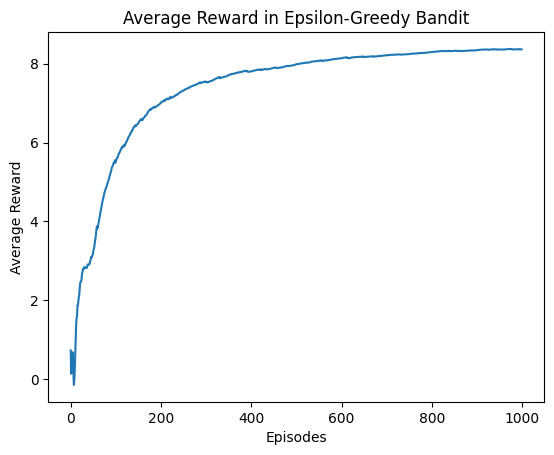

Q-Values: [-0.06699695  1.25038833  2.56144986  3.30018574  3.54444956  5.20625911
  6.33501181  6.64611343  8.0997116   9.0339344 ]


In [ ]:
def epsilon_greedy_bandit(k, episodes, epsilon=0.1):
    q_values = np.zeros(k)
    action_counts = np.zeros(k)
    total_rewards = np.zeros(episodes)
    avg_rewards = np.zeros(episodes)

    for episode in range(episodes):
        if np.random.rand() < epsilon:
            action = np.random.choice(k)
        else:
            action = np.argmax(q_values)

        # Simulate reward (here we use a normal distribution centered around action index)
        reward = np.random.normal(loc=action, scale=1.0)

        action_counts[action] += 1
        q_values[action] += (reward - q_values[action]) / action_counts[action]
        total_rewards[episode] = reward
        avg_rewards[episode] = np.mean(total_rewards[:episode + 1])

    return q_values, avg_rewards

k = 10  # Number of arms
episodes = 1000
epsilon = 0.1
q_values, avg_rewards = epsilon_greedy_bandit(k, episodes, epsilon)

# Plotting average rewards over episodes
plt.plot(np.arange(episodes), avg_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward in Epsilon-Greedy Bandit')
plt.show()

print("Q-Values:", q_values)


### UCB for Multi-Armed Bandit


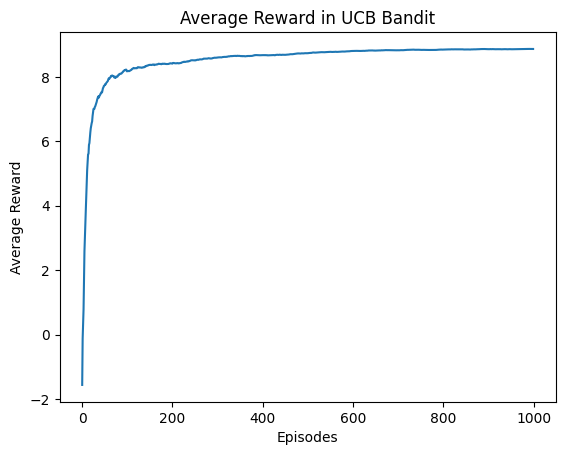

Q-Values (UCB): [-1.56449711  1.30820272  1.09855534  2.27723587  4.35493011  6.34376142
  5.2207314   7.25491775  8.30707016  8.97072155]


In [ ]:
def ucb_bandit(k, episodes, c=2):
    q_values = np.zeros(k)
    action_counts = np.zeros(k)
    total_rewards = np.zeros(episodes)
    avg_rewards = np.zeros(episodes)

    for episode in range(episodes):
        ucb_values = q_values + c * np.sqrt(np.log(episode + 1) / (action_counts + 1e-5))
        action = np.argmax(ucb_values)

        # Simulate reward (here we use a normal distribution centered around action index)
        reward = np.random.normal(loc=action, scale=1.0)

        action_counts[action] += 1
        q_values[action] += (reward - q_values[action]) / action_counts[action]
        total_rewards[episode] = reward
        avg_rewards[episode] = np.mean(total_rewards[:episode + 1])

    return q_values, avg_rewards

k = 10  # Number of arms
episodes = 1000
c = 2
q_values_ucb, avg_rewards_ucb = ucb_bandit(k, episodes, c)

# Plotting average rewards over episodes
plt.plot(np.arange(episodes), avg_rewards_ucb)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward in UCB Bandit')
plt.show()

print("Q-Values (UCB):", q_values_ucb)
